# Сделано через лес :-(>

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_excel("dataset.xlsx", sheet_name='dataset', header=0)
X = df.drop(['Дата',
             'I БС3 отн.',
             'I БС4 отн.',
             'Uхх БС3 отн.',
             'Uхх БС4 отн.'], axis=1)
Y = df.drop(['Дата',
             'Протоны >1 MeV',
             'Протоны >10 MeV',
             'Протоны >100 MeV',
             'Электроны >0.6 MeV',
             'Электроны >2 MeV',
             'К осв-ти'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X))

def build_and_compile_model_params(hp):

    n_neurons = hp.Int('n_neurons', min_value=32, max_value=512, step=32)
    n_out = hp.Int('n_out', min_value=1, max_value=4, step=1)
    activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    optimizer = hp.Choice('optimizer', values=['Adam', 'SGD'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    #optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss = hp.Choice('loss', values=['mse', 'mae', 'mape'])
    metric = hp.Choice('metric', values=['mse', 'mae'])

    model = keras.Sequential([
        normalizer,
        layers.Dense(n_neurons, activation=activation),
        layers.Dense(n_out)
    ])

    model.compile(
        optimizer=getattr(tf.keras.optimizers, optimizer)(learning_rate=learning_rate),
        loss=loss,
        metrics=[metric]
    )

    return model

# RandomSearch
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_and_compile_model_params,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='random_search',
    project_name='battery_regression'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

INFO:tensorflow:Reloading Tuner from random_search\battery_regression\tuner0.json


C:\Users\ivan\AppData\Local\Temp\ipykernel_14552\2500142640.py:53: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
Traceback (most recent call last):
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\tuner.


Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
352               |384               |n_neurons
2                 |4                 |n_out
tanh              |relu              |activation
rmsprop           |Adam              |optimizer
0.0045065         |0.00092494        |learning_rate
mape              |mae               |loss
mse               |mse               |metric



RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\ivan\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "C:\Users\ivan\AppData\Local\Temp\ipykernel_14552\2500142640.py", line 45, in build_and_compile_model_params
    optimizer=getattr(tf.keras.optimizers, optimizer)(learning_rate=learning_rate),
AttributeError: module 'keras.api._v2.keras.optimizers' has no attribute 'rmsprop'


In [42]:
 Y_test.shape

(15, 4)

# RandomSearch (Попытка 2)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

def build_model(hyperparams):
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(units=hyperparams.Int("units_l1", 16, 50, step=16),
                           use_bias=hyperparams.Boolean("bias_l1"),
                           activation=hyperparams.Choice("act_l1", ["relu", "tanh"])
                          ))
    model.add(layers.Dense(units=hyperparams.Int("units_l2", 16, 50, step=16),
                           use_bias=hyperparams.Boolean("bias_l2"),
                           activation=hyperparams.Choice("act_l2", ["relu", "tanh"])
                          ))
    model.add(layers.Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_squared_error"])

    return model

In [3]:
from keras_tuner import RandomSearch
from keras_tuner import Objective

tuner1 =  RandomSearch(hypermodel=build_model,
                      objective="val_mean_squared_error",
                      #objective=Objective(name="val_mean_squared_error",direction="min"),
                      max_trials=15,
                      #seed=123,
                      project_name="Regression2",
                      overwrite=True
                    )

In [4]:
tuner1.search(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

Trial 15 Complete [00h 00m 02s]
val_mean_squared_error: 0.0012134077260270715

Best val_mean_squared_error So Far: 0.0011361391516402364
Total elapsed time: 00h 00m 27s
INFO:tensorflow:Oracle triggered exit


In [5]:
best_params = tuner1.get_best_hyperparameters()

best_params[0].values

{'units_l1': 32,
 'bias_l1': True,
 'act_l1': 'relu',
 'units_l2': 48,
 'bias_l2': False,
 'act_l2': 'tanh',
 'optimizer': 'rmsprop'}

In [6]:
best_model = tuner1.get_best_models()[0]

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 48)                1536      
                                                                 
 dense_2 (Dense)             (None, 1)                 49        
                                                                 
Total params: 1,809
Trainable params: 1,809
Non-trainable params: 0
_________________________________________________________________


In [14]:
Y_test_reg_preds = best_model.predict(X_test)

Y_test[:5], Y_test_reg_preds[:5]

1/1 [==============================] - 0s 76ms/step


(     I БС3 отн.  I БС4 отн.  Uхх БС3 отн.  Uхх БС4 отн.
 100    0.905433     0.96336       0.92297      0.915680
 121    0.864337     0.91433       0.90087      0.896530
 54     0.896523     0.93750       0.93452      0.926405
 104    0.897070     0.96336       0.92297      0.912970
 99     0.905433     0.96336       0.92297      0.912970,
 array([[0.9282456],
        [0.9282456],
        [0.9282456],
        [0.9282456],
        [0.9282456]], dtype=float32))

In [10]:
tuner1.results_summary(num_trials=1)

Results summary
Results in .\Regression2
Showing 1 best trials
Trial summary
Hyperparameters:
units_l1: 32
bias_l1: True
act_l1: relu
units_l2: 48
bias_l2: False
act_l2: tanh
optimizer: rmsprop
Score: 0.0011361391516402364


In [13]:
tuner1.get_best_hyperparameters()[0].values

{'units_l1': 32,
 'bias_l1': True,
 'act_l1': 'relu',
 'units_l2': 48,
 'bias_l2': False,
 'act_l2': 'tanh',
 'optimizer': 'rmsprop'}

# Bayesian Optimization Algorithm 

In [40]:
from keras_tuner import BayesianOptimization
from keras_tuner import Objective


tuner7 =  BayesianOptimization(hypermodel=build_model,
                               objective="val_mean_squared_error",
                               max_trials=10,
                               num_initial_points=2,
                               #seed=123
                               project_name="BayesianOptimization",
                               overwrite=True
                              )

tuner7.search(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

Trial 10 Complete [00h 00m 01s]
val_mean_squared_error: 0.0018969329539686441

Best val_mean_squared_error So Far: 0.0011360821081325412
Total elapsed time: 00h 00m 24s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_params = tuner7.get_best_hyperparameters()

best_params[0].values

{'units_l1': 32,
 'bias_l1': False,
 'act_l1': 'tanh',
 'units_l2': 32,
 'bias_l2': True,
 'act_l2': 'relu',
 'optimizer': 'rmsprop'}

In [43]:
best_model = tuner7.get_best_models()[0]

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


# GridSearch

In [35]:
from keras_tuner import GridSearch
from keras_tuner import Objective

tuner5 =  BayesianOptimization(hypermodel=build_model,
                               objective="val_mean_squared_error",
                               max_trials=10,
                               num_initial_points=2,
                               #seed=123
                               project_name="GridSearchOptimization",
                               overwrite=True
                              )

tuner5.search(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

Trial 10 Complete [00h 00m 01s]
val_mean_squared_error: 0.0011437570210546255

Best val_mean_squared_error So Far: 0.0011211385717615485
Total elapsed time: 00h 00m 19s
INFO:tensorflow:Oracle triggered exit


In [36]:
best_params = tuner5.get_best_hyperparameters()

best_params[0].values

{'units_l1': 32,
 'bias_l1': True,
 'act_l1': 'tanh',
 'units_l2': 32,
 'bias_l2': False,
 'act_l2': 'tanh',
 'optimizer': 'sgd'}

In [37]:
best_model = tuner5.get_best_models()[0]

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 32)                1024      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


# Плавающее число слоев

In [12]:
np.random.randint(10)

9

In [22]:
def build_model_layers(hyperparams):
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    layer = np.random.randint(10)
    
    for i in range(layer):
         model.add(layers.Dense(units=hyperparams.Int("units_l2", 16, 50, step=16),
                           use_bias=hyperparams.Boolean("bias_l2"),
                           activation=hyperparams.Choice("act_l2", ["relu", "tanh"])
                          ))
    

   
    model.add(layers.Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_squared_error"])

    return model

In [35]:
from keras_tuner import RandomSearch
from keras_tuner import Objective

tuner2 =  RandomSearch(hypermodel=build_model_layers,
                      objective="val_mean_squared_error",
                      #objective=Objective(name="val_mean_squared_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="RegressionLayers",
                      overwrite=True
                    )

In [36]:
tuner2.search(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

Trial 5 Complete [00h 00m 01s]
val_mean_squared_error: 0.0011367719853296876

Best val_mean_squared_error So Far: 0.0011367719853296876
Total elapsed time: 00h 00m 07s
INFO:tensorflow:Oracle triggered exit


In [37]:
best_params = tuner2.get_best_hyperparameters()

best_params[0].values

{'optimizer': 'rmsprop', 'units_l2': 32, 'bias_l2': False, 'act_l2': 'tanh'}

In [38]:
best_model = tuner2.get_best_models()[0]

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                1024      
                                                                 
 dense_2 (Dense)             (None, 32)                1024      
                                                                 
 dense_3 (Dense)             (None, 32)                1024      
                                                                 
 dense_4 (Dense)             (None, 32)                1024      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainabl

In [50]:
from keras_tuner import BayesianOptimization

tuner3 =  BayesianOptimization(hypermodel=build_model_lyaers,
                               objective="val_mean_squared_error",
                               max_trials=4,
                               num_initial_points=2,
                               #seed=123
                               project_name="BayesianOptimizationLayers",
                               overwrite=True
                              )

tuner3.search(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

Trial 4 Complete [00h 00m 02s]
val_mean_squared_error: 0.0010637643281370401

Best val_mean_squared_error So Far: 0.0010637643281370401
Total elapsed time: 00h 00m 06s
INFO:tensorflow:Oracle triggered exit


In [51]:
best_params = tuner3.get_best_hyperparameters()

best_params[0].values

{'units_l2': 32, 'bias_l2': True, 'act_l2': 'tanh', 'optimizer': 'sgd'}

In [52]:
best_model = tuner3.get_best_models()[0]

best_model.summary()

ValueError: Received incompatible tensor with shape (32,) when attempting to restore variable with shape (1,) and name layer_with_weights-3/bias/.ATTRIBUTES/VARIABLE_VALUE.

# Hyperband

In [33]:
from keras_tuner import Hyperband

In [35]:
tuner4 =  Hyperband(hypermodel=build_model,
                               objective="val_mean_squared_error",
                               project_name="Hyperband",
                               overwrite=True
                              )

tuner4.search(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

Trial 202 Complete [00h 00m 05s]
val_mean_squared_error: 2560219676672.0

Best val_mean_squared_error So Far: 0.001082893111743033
Total elapsed time: 00h 03m 43s
INFO:tensorflow:Oracle triggered exit


In [36]:
best_params4 = tuner4.get_best_hyperparameters()

best_params4[0].values

{'units_l1': 32,
 'bias_l1': False,
 'act_l1': 'relu',
 'units_l2': 32,
 'bias_l2': False,
 'act_l2': 'tanh',
 'optimizer': 'rmsprop',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [37]:
best_model4 = tuner4.get_best_models()[0]

best_model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                1024      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [38]:
tuner4.results_summary(num_trials=10)

Results summary
Results in .\Hyperband
Showing 10 best trials
Trial summary
Hyperparameters:
units_l1: 32
bias_l1: False
act_l1: relu
units_l2: 32
bias_l2: False
act_l2: tanh
optimizer: rmsprop
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.001082893111743033
Trial summary
Hyperparameters:
units_l1: 48
bias_l1: False
act_l1: tanh
units_l2: 16
bias_l2: True
act_l2: tanh
optimizer: sgd
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.0011358618503436446
Trial summary
Hyperparameters:
units_l1: 32
bias_l1: True
act_l1: relu
units_l2: 48
bias_l2: False
act_l2: tanh
optimizer: adam
tuner/epochs: 34
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.001135862316004932
Trial summary
Hyperparameters:
units_l1: 32
bias_l1: True
act_l1: tanh
units_l2: 16
bias_l2: False
act_l2: relu
optimizer: sgd
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0011358644114807248
Trial summary
Hyperpa

# AutoKeras

In [9]:
import autokeras as ak

In [10]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_set = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [7]:
reg = ak.StructuredDataRegressor(max_trials=10, overwrite=True, project_name="AutoKeras")
# Feed the tensorflow Dataset to the regressor.
reg.fit(train_set, epochs=10)
# Predict with the best model.
predicted_y = reg.predict(test_set)
# Evaluate the best model with testing data.
print(reg.evaluate(test_set))


Trial 10 Complete [00h 00m 02s]
val_loss: 0.0007045958191156387

Best val_loss So Far: 0.0007045958191156387
Total elapsed time: 00h 00m 28s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
5/5 [==============================] - 0s 6ms/step - loss: 1.5199 - mean_squared_error: 1.5199
Epoch 2/10
5/5 [==============================] - 0s 6ms/step - loss: 2.5948 - mean_squared_error: 2.5948
Epoch 3/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0517 - mean_squared_error: 0.0517
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0394 - mean_squared_error: 0.0394
Epoch 5/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 8/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0023 - 

In [8]:
best_model = reg.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [7]:
reg2 = ak.StructuredDataRegressor(max_trials=3,
                                  overwrite=True,
                                  project_name="AutoKeras4",
                                  loss='mean_absolute_error',
                                  metrics = 'accuracy'
                                  )
# Feed the tensorflow Dataset to the regressor.
REGG = reg2.fit(train_set, verbose=True, epochs=50)
# Predict with the best model.
#predicted_y = reg2.predict(test_set)
# Evaluate the best model with testing data.
#print(reg2.evaluate(test_set))

Trial 3 Complete [00h 00m 07s]
val_loss: 0.010311031714081764

Best val_loss So Far: 0.010311031714081764
Total elapsed time: 00h 00m 24s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
5/5 [==============================] - 0s 8ms/step - loss: 0.8594 - accuracy: 0.0376
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.6379 - accuracy: 0.0376
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.4129 - accuracy: 0.0376
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2849 - accuracy: 0.0602
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.2686 - accuracy: 0.2481
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.2145 - accuracy: 0.2932
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.1755 - accuracy: 0.4286
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1548 - accuracy: 0.3910
Epoch 9/50
5/5 [==============================] - 0s 5ms

In [8]:
hist = pd.DataFrame(REGG.history)

In [9]:
hist['epoch'] = REGG.epoch

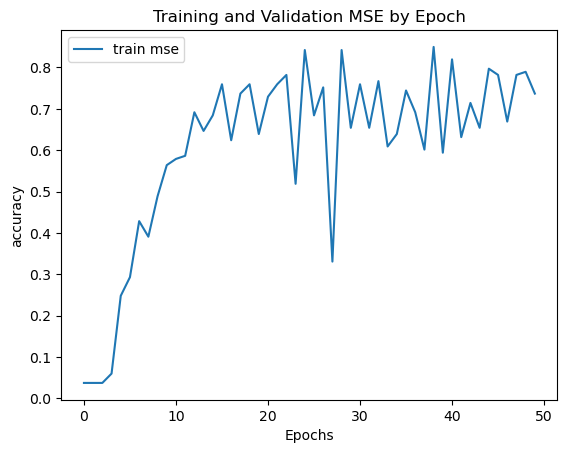

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist['epoch'], hist['accuracy'], label='train mse')
#plt.plot(hist['epoch'], hist['val_accuracy'], label='val mse')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Training and Validation MSE by Epoch')
plt.legend()
plt.show()

In [18]:
best_model2 = reg2.export_model()
best_model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 512)               16896 

In [35]:
hist_list = []
for i in range(10):
    reg3 = ak.StructuredDataRegressor(max_trials=1,
                                  overwrite=True,
                                  project_name=f"AutoKeras{6+i}",
                                  loss='mean_absolute_error',
                                  metrics = 'accuracy')
    
    REG = reg3.fit(train_set, verbose=True, epochs=50)
    hist_i = REG.history
    hist_list.append(hist_i)
    

Trial 1 Complete [00h 00m 08s]
val_loss: 0.05082966759800911

Best val_loss So Far: 0.05082966759800911
Total elapsed time: 00h 00m 08s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
5/5 [==============================] - 0s 6ms/step - loss: 0.9151 - accuracy: 0.6617
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 0.8399 - accuracy: 0.6541
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.7686 - accuracy: 0.6165
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6948 - accuracy: 0.6165
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6241
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.5520 - accuracy: 0.6090
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.4813 - accuracy: 0.5940
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.4138 - accuracy: 0.5789
Epoch 9/50
5/5 [==============================] - 0s 7ms/s

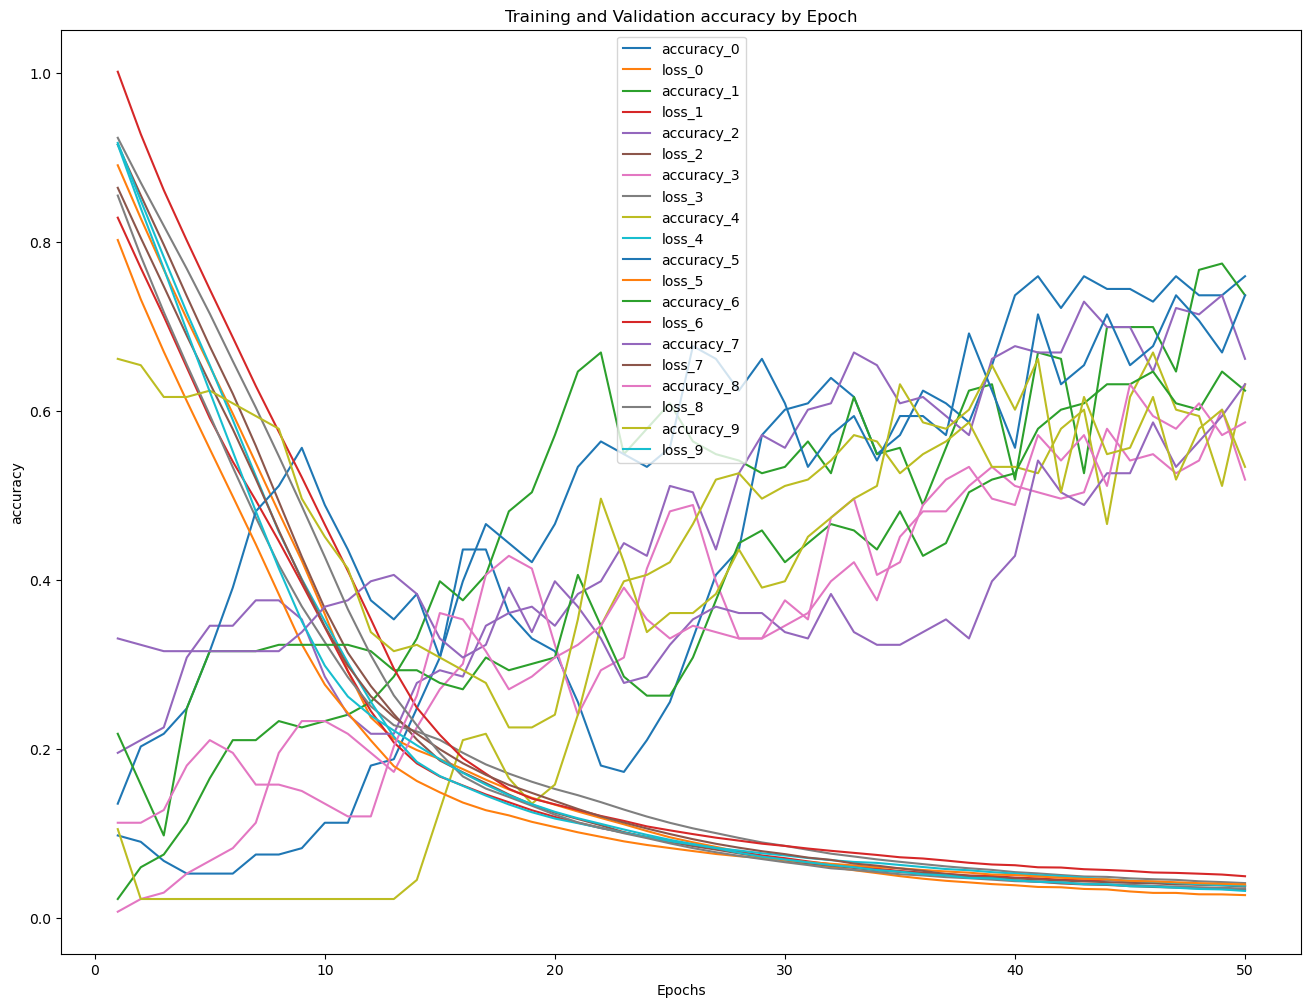

In [37]:
plt.figure(figsize=(16,12))
for k in range(10):
    plt.plot(list(np.arange(1,51)), hist_list[k]['accuracy'], label=f'accuracy_{k}')
    plt.plot(list(np.arange(1,51)), hist_list[k]['loss'], label=f'loss_{k}')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy by Epoch')
plt.legend()
plt.show()

In [12]:
reloaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               1792      
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896 

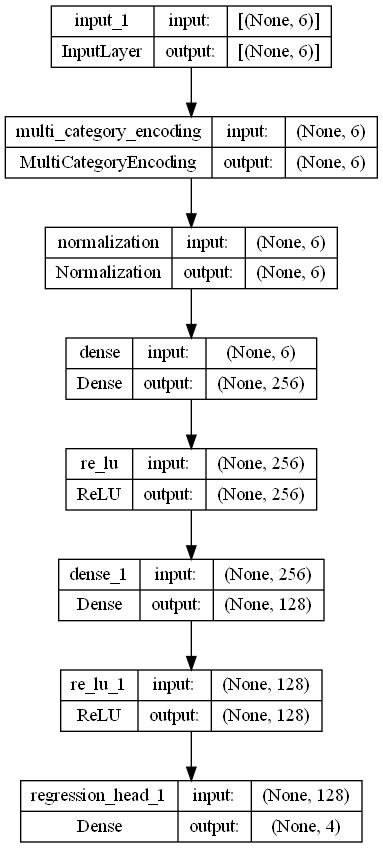

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(reloaded_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

for k in range(500):
    plot_model(sum_i_list[k], to_file=f'model_plot{k}.png', show_shapes=True, show_layer_names=True)

In [8]:
hist_list = []
summary_list = []
for i in range(2):
    reg3 = ak.StructuredDataRegressor(max_trials=3,
                                  overwrite=True,
                                  project_name=f"AutoKeras{16+i}",
                                  loss='mean_absolute_error',
                                  metrics = 'accuracy')
    
    REG = reg3.fit(train_set, verbose=True, epochs=50)
    hist_i = REG.history
    best_model_i = reg3.export_model()
    hist_list.append(hist_i)
    summary_list.append(best_model_i)

Trial 3 Complete [00h 00m 09s]
val_loss: 0.10133471339941025

Best val_loss So Far: 0.06347785890102386
Total elapsed time: 00h 00m 26s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
5/5 [==============================] - 0s 6ms/step - loss: 0.8829 - accuracy: 0.5865
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8015 - accuracy: 0.5865
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7262 - accuracy: 0.5639
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6551 - accuracy: 0.5414
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5852 - accuracy: 0.5414
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5155 - accuracy: 0.5414
Epoch 7/50
5/5 [==============================] - 0s 6ms/step - loss: 0.4568 - accuracy: 0.5414
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4018 - accuracy: 0.5489
Epoch 9/50
5/5 [==============================] - 0s 6ms/s

In [12]:
summary_list

In [13]:
summ_final = []
for g in range(2):
    summ = summary_list[g].summary()
    summ_final.append(summ)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [22]:
for h in range(2):
    plot_model(summary_list[h], to_file=f'model_plot{h}.png', show_shapes=True, show_layer_names=True)

In [29]:
predict_list = []
for p in range(2):
    predict_i = summary_list[p].predict(test_set)
    predict_list.append(predict_i)

15/15 [==============================] - 0s 2ms/step


In [30]:
predict_list

[array([[0.8691356 , 0.9084671 , 0.85191774, 0.82715887],
        [0.8895164 , 0.82228494, 0.86232144, 0.82972705],
        [0.9226741 , 1.0216116 , 1.0821896 , 1.1399167 ],
        [0.88329786, 0.95978075, 0.90616447, 0.9037686 ],
        [0.8787212 , 0.97054344, 0.8854228 , 0.886031  ],
        [0.92535394, 0.8479345 , 0.90988874, 0.86187226],
        [0.8821891 , 1.0104338 , 0.8776626 , 0.8868443 ],
        [0.78209156, 0.7441209 , 0.7086052 , 0.7099091 ],
        [0.83101416, 0.8281617 , 0.82065046, 0.79808027],
        [0.89343375, 0.95079905, 0.89133537, 0.864207  ],
        [0.8186008 , 0.8568751 , 0.90819937, 0.8948799 ],
        [0.9283539 , 0.9106506 , 1.0452877 , 1.0443829 ],
        [0.9065879 , 0.962035  , 0.85912865, 0.8380872 ],
        [0.99038917, 0.96502477, 1.1039485 , 1.1176085 ],
        [0.8986519 , 0.9222467 , 0.86858916, 0.832314  ]], dtype=float32),
 array([[0.8374959 , 0.90805864, 0.84270364, 0.8688574 ],
        [0.79164094, 0.8797574 , 0.8004297 , 0.90542257

In [37]:
summary_list[0].summary().g

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

AttributeError: 'NoneType' object has no attribute 'get_config'

In [43]:
summary_list[1].summary(
    expand_nested=True,
    show_trainable=True,
)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 6)]               0         Y          
                                                                            
 multi_category_encoding (Mu  (None, 6)                0         Y          
 ltiCategoryEncoding)                                                       
                                                                            
 normalization (Normalizatio  (None, 6)                13        Y          
 n)                                                                         
                                                                            
 dense (Dense)               (None, 32)                224       Y          
                                                                            
 re_lu (ReLU)                (None, 32)                0     

In [45]:
summary_list[1].save("my_h5_model.h5")

In [14]:
reconstructed_model = keras.models.load_model("my_h5_model.h5")

# Let's check:
reconstructed_model.fit(train_set, verbose=True, epochs=200)


Epoch 1/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0582 - accuracy: 0.1955
Epoch 2/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0534 - accuracy: 0.2105
Epoch 3/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0460 - accuracy: 0.2331
Epoch 4/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0486 - accuracy: 0.2406
Epoch 5/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0430 - accuracy: 0.2331
Epoch 6/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0509 - accuracy: 0.2707
Epoch 7/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0382 - accuracy: 0.2782
Epoch 8/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0417 - accuracy: 0.3008
Epoch 9/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0387 - accuracy: 0.2030
Epoch 10/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0378 - accura

Epoch 76/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0314 - accuracy: 0.2707
Epoch 77/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0285 - accuracy: 0.2481
Epoch 78/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0311 - accuracy: 0.3083
Epoch 79/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0276 - accuracy: 0.2030
Epoch 80/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0289 - accuracy: 0.3233
Epoch 81/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0281 - accuracy: 0.2256
Epoch 82/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0284 - accuracy: 0.3308
Epoch 83/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0285 - accuracy: 0.1053
Epoch 84/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0278 - accuracy: 0.2331
Epoch 85/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0277

KeyboardInterrupt: 

In [50]:
summary_list[1].save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


In [15]:
reloaded_model = keras.models.load_model("my_h5_model_481.h5")

# Let's check:
reloaded_model.fit(train_set, verbose=True, epochs=200)

Epoch 1/200
133/133 [==============================] - 2s 7ms/step - loss: 0.0356 - accuracy: 0.2782
Epoch 2/200
133/133 [==============================] - 1s 7ms/step - loss: 0.1135 - accuracy: 0.2406
Epoch 3/200
133/133 [==============================] - 1s 7ms/step - loss: 0.0359 - accuracy: 0.3383
Epoch 4/200
133/133 [==============================] - 1s 7ms/step - loss: 0.0296 - accuracy: 0.2782
Epoch 5/200
133/133 [==============================] - 1s 7ms/step - loss: 0.0296 - accuracy: 0.2857
Epoch 6/200
133/133 [==============================] - 1s 7ms/step - loss: 0.0283 - accuracy: 0.2256
Epoch 7/200
133/133 [==============================] - 1s 7ms/step - loss: 0.0274 - accuracy: 0.0000e+00
Epoch 8/200
133/133 [==============================] - 1s 7ms/step - loss: 0.0274 - accuracy: 0.0000e+00
Epoch 9/200
133/133 [==============================] - 1s 7ms/step - loss: 0.0274 - accuracy: 0.0000e+00
Epoch 10/200
133/133 [==============================] - 1s 7ms/step - loss: 0.0

KeyboardInterrupt: 

In [20]:
fit = reloaded_model.fit(train_set)

133/133 [==============================] - 1s 7ms/step - loss: 0.0274 - accuracy: 0.0000e+00


In [21]:
fit.history

{'loss': [0.0273672416806221], 'accuracy': [0.0]}

In [56]:
summary_list[1].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [57]:
reconstructed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [58]:
saves_list_models = []
for e in range(2):
    saved_i = summary_list[e].save(f"my_h5_model{e}.h5")
    saves_list_models.append(saved_i)

In [61]:
reconstructed_list_models = []
for u in range(2):
    reconstructed_model = keras.models.load_model(f"my_h5_model{u}.h5") 
    reconstructed_list_models.append(reconstructed_model)

In [63]:
reconstructed_list_models[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [64]:
saves_list_models_alternative = []
for l in range(2):
    saved_l = summary_list[l].save(f"my_model_{l}")
    saves_list_models_alternative.append(saved_l)

INFO:tensorflow:Assets written to: my_model_0\assets
INFO:tensorflow:Assets written to: my_model_1\assets


In [66]:
list_models_reloaded_alternative = []
for t in range(2):
    model_alternative = keras.models.load_model(f"my_model_{t}")
    list_models_reloaded_alternative.append(model_alternative)

In [67]:
list_models_reloaded_alternative[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [3]:
h46 = pd.read_excel('hist_46.xlsx')

In [4]:
len(h46['accuracy'])

200

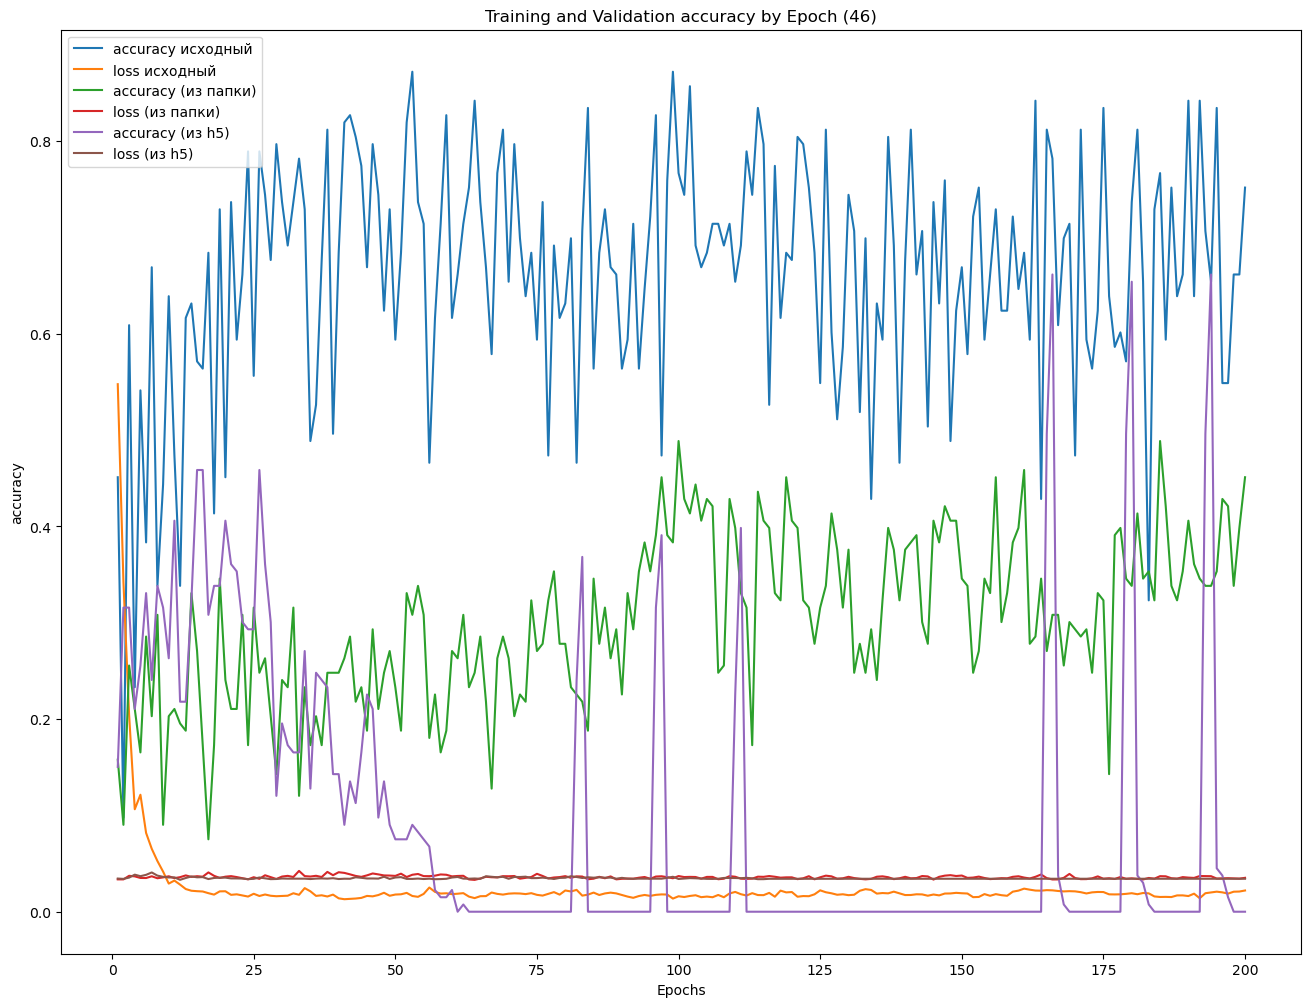

In [120]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
#for k in range(10):
plt.plot(list(np.arange(1,len(h46['accuracy'])+1)), h46['accuracy'], label=f'accuracy исходный')
plt.plot(list(np.arange(1,len(h46['accuracy'])+1)), h46['loss'], label=f'loss исходный')

plt.plot(list(np.arange(1,len(h46['accuracy'])+1)), fit46_new['accuracy'], label=f'accuracy (из папки)')
plt.plot(list(np.arange(1,len(h46['accuracy'])+1)), fit46_new['loss'], label=f'loss (из папки)')

plt.plot(list(np.arange(1,len(h46['accuracy'])+1)), h5_hist['accuracy'], label=f'accuracy (из h5)')
plt.plot(list(np.arange(1,len(h46['accuracy'])+1)), h5_hist['loss'], label=f'loss (из h5)')

plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy by Epoch (46)')
plt.legend()
plt.show()

# Работа с попытками

In [43]:
trial_i = pd.read_json('AutoKeras46/trial_00/trial.json')
trial_i

,trial_id,hyperparameters,metrics,score,best_step,status,message
space,0,"[{'class_name': 'Boolean', 'config': {'name': ...",NaN,0.011809,148,COMPLETED,NaN
values,0,"{'structured_data_block_1/normalize': True, 's...",NaN,0.011809,148,COMPLETED,NaN
metrics,0,NaN,"{'loss': {'direction': 'min', 'observations': ...",0.011809,148,COMPLETED,NaN


In [46]:
trial_i.loc['values']['hyperparameters']

{'structured_data_block_1/normalize': True,
 'structured_data_block_1/dense_block_1/num_layers': 2,
 'structured_data_block_1/dense_block_1/use_batchnorm': False,
 'structured_data_block_1/dense_block_1/dropout': 0,
 'structured_data_block_1/dense_block_1/units_0': 32,
 'structured_data_block_1/dense_block_1/units_1': 32,
 'regression_head_1/dropout': 0.0,
 'optimizer': 'adam',
 'learning_rate': 0.001}

In [52]:
trial_i.loc['metrics']['metrics']

{'loss': {'direction': 'min',
  'observations': [{'value': [0.010194385424256], 'step': 148}]},
 'accuracy': {'direction': 'max',
  'observations': [{'value': [0.7265625], 'step': 148}]},
 'val_loss': {'direction': 'min',
  'observations': [{'value': [0.011809283867478001], 'step': 148}]},
 'val_accuracy': {'direction': 'max',
  'observations': [{'value': [0.600000023841857], 'step': 148}]}}

In [38]:
import json
with open('trial.json') as datafile:
    data = json.load(datafile)
retail = pd.DataFrame(data)
retail

,trial_id,hyperparameters,metrics,score,best_step,status,message
space,00,"[{'class_name': 'Boolean', 'config': {'name': ...",NaN,0.011809,148,COMPLETED,None
values,00,"{'structured_data_block_1/normalize': True, 's...",NaN,0.011809,148,COMPLETED,None
metrics,00,NaN,"{'loss': {'direction': 'min', 'observations': ...",0.011809,148,COMPLETED,None


In [41]:
pd.read_json('trial.json', orient=str)

,trial_id,hyperparameters,metrics,score,best_step,status,message
space,0,"[{'class_name': 'Boolean', 'config': {'name': ...",NaN,0.011809,148,COMPLETED,NaN
values,0,"{'structured_data_block_1/normalize': True, 's...",NaN,0.011809,148,COMPLETED,NaN
metrics,0,NaN,"{'loss': {'direction': 'min', 'observations': ...",0.011809,148,COMPLETED,NaN


In [112]:
latest = tf.train.latest_checkpoint('AutoKeras46/trial_00')


In [64]:
reader = tf.train.load_checkpoint('AutoKeras46/trial_40')
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()


In [62]:
shape_from_key

{'optimizer/_variables/2/.ATTRIBUTES/VARIABLE_VALUE': [32],
 'optimizer/_iterations/.ATTRIBUTES/VARIABLE_VALUE': [],
 'layer_with_weights-0/variance/.ATTRIBUTES/VARIABLE_VALUE': [6],
 '_CHECKPOINTABLE_OBJECT_GRAPH': [],
 'layer_with_weights-0/count/.ATTRIBUTES/VARIABLE_VALUE': [],
 'layer_with_weights-0/mean/.ATTRIBUTES/VARIABLE_VALUE': [6],
 'layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE': [6, 32],
 'optimizer/_variables/3/.ATTRIBUTES/VARIABLE_VALUE': [32],
 'layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE': [32],
 'layer_with_weights-2/bias/.ATTRIBUTES/VARIABLE_VALUE': [4],
 'layer_with_weights-2/kernel/.ATTRIBUTES/VARIABLE_VALUE': [32, 4],
 'optimizer/_current_learning_rate/.ATTRIBUTES/VARIABLE_VALUE': [],
 'optimizer/_variables/0/.ATTRIBUTES/VARIABLE_VALUE': [6, 32],
 'optimizer/_variables/1/.ATTRIBUTES/VARIABLE_VALUE': [6, 32],
 'optimizer/_variables/4/.ATTRIBUTES/VARIABLE_VALUE': [32, 4],
 'optimizer/_variables/5/.ATTRIBUTES/VARIABLE_VALUE': [32, 4],
 'optimizer/_va

In [63]:
dtype_from_key

{'optimizer/_variables/2/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'optimizer/_iterations/.ATTRIBUTES/VARIABLE_VALUE': tf.int64,
 'layer_with_weights-0/variance/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 '_CHECKPOINTABLE_OBJECT_GRAPH': tf.string,
 'layer_with_weights-0/count/.ATTRIBUTES/VARIABLE_VALUE': tf.int64,
 'layer_with_weights-0/mean/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'optimizer/_variables/3/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'layer_with_weights-2/bias/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'layer_with_weights-2/kernel/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'optimizer/_current_learning_rate/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'optimizer/_variables/0/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'optimizer/_variables/1/.ATTRIBUTES/VARIABLE_VALUE': tf.float32,
 'optimizer/_variables/4/.ATTRIBUTES/VARIABLE_VALUE': tf.float3

# Загрузка из папки лучшей модели

In [71]:
model = keras.models.load_model('AutoKeras46/best_model')

In [72]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 regression_head_1 (Dense)   (None, 4)                 132   

In [103]:
fitting = model.fit(train_set, epochs=200)

Epoch 1/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0336 - accuracy: 0.1579
Epoch 2/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0336 - accuracy: 0.0902
Epoch 3/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0373 - accuracy: 0.2556
Epoch 4/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0367 - accuracy: 0.2105
Epoch 5/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0351 - accuracy: 0.1654
Epoch 6/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0350 - accuracy: 0.2857
Epoch 7/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0368 - accuracy: 0.2030
Epoch 8/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0348 - accuracy: 0.3083
Epoch 9/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0356 - accuracy: 0.0902
Epoch 10/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0368 - accura

133/133 [==============================] - 0s 3ms/step - loss: 0.0352 - accuracy: 0.2331
Epoch 82/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0367 - accuracy: 0.2256
Epoch 83/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0365 - accuracy: 0.2180
Epoch 84/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0337 - accuracy: 0.1880
Epoch 85/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0343 - accuracy: 0.3459
Epoch 86/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0362 - accuracy: 0.2782
Epoch 87/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0348 - accuracy: 0.3158
Epoch 88/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0367 - accuracy: 0.2632
Epoch 89/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0336 - accuracy: 0.2932
Epoch 90/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0342 - accuracy: 

133/133 [==============================] - 1s 4ms/step - loss: 0.0368 - accuracy: 0.3985
Epoch 161/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0355 - accuracy: 0.4586
Epoch 162/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0345 - accuracy: 0.2782
Epoch 163/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0363 - accuracy: 0.2857
Epoch 164/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0386 - accuracy: 0.3459
Epoch 165/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0349 - accuracy: 0.2707
Epoch 166/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0335 - accuracy: 0.3083
Epoch 167/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0335 - accuracy: 0.3083
Epoch 168/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0352 - accuracy: 0.2556
Epoch 169/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0392 - a

In [107]:
fit46_new =  pd.DataFrame(fitting.history)

In [76]:
config = model.get_config()
new_model = keras.Sequential.from_config(config)

In [89]:
json_config = model.to_json()
new_model = keras.models.model_from_json(json_config)

In [90]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 regression_head_1 (Dense)   (None, 4)                 132   

In [98]:
new_model.compile(optimizer="adam", loss='mean_absolute_error',
                                  metrics = 'accuracy')

In [100]:
new_model.fit(train_set, epochs=50)

Epoch 1/50
133/133 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/50
133/133 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/50
133/133 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/50
133/133 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/50
133/133 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/50
133/133 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/50
133/133 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/50
133/133 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/50
133/133 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/50
133/133 [==============================] - 0s 3ms/step - loss: nan - accuracy: 

In [122]:
new_model.evaluate(test_set)

15/15 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00


[nan, 0.0]

# Загрузка из h5 файла лучшей модели

In [110]:
h5_model46 = keras.models.load_model("my_h5_model_46.h5")

In [111]:
h5_model46.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 regression_head_1 (Dense)   (None, 4)                 132   

In [115]:
h5_fitted = h5_model46.fit(train_set, epochs=200)

Epoch 1/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0344 - accuracy: 0.1504
Epoch 2/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0341 - accuracy: 0.3158
Epoch 3/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.3158
Epoch 4/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0385 - accuracy: 0.2105
Epoch 5/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0369 - accuracy: 0.2556
Epoch 6/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.3308
Epoch 7/200
133/133 [==============================] - 1s 4ms/step - loss: 0.0408 - accuracy: 0.2406
Epoch 8/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0375 - accuracy: 0.3383
Epoch 9/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0362 - accuracy: 0.3158
Epoch 10/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0356 - accura

133/133 [==============================] - 0s 3ms/step - loss: 0.0353 - accuracy: 0.0000e+00
Epoch 81/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0369 - accuracy: 0.0000e+00
Epoch 82/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0361 - accuracy: 0.2406
Epoch 83/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0351 - accuracy: 0.3684
Epoch 84/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0358 - accuracy: 0.0000e+00
Epoch 85/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0353 - accuracy: 0.0000e+00
Epoch 86/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0357 - accuracy: 0.0000e+00
Epoch 87/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0353 - accuracy: 0.0000e+00
Epoch 88/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0354 - accuracy: 0.0000e+00
Epoch 89/200
133/133 [==============================] - 0s 3ms/step

133/133 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 158/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 159/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 160/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 161/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 162/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 163/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 164/200
133/133 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 165/200
133/133 [==============================] - 0s 4ms/step - loss: 0.0342 - accuracy: 0.4962
Epoch 166/200
133/133 [==============================] 

In [117]:
h5_hist = pd.DataFrame(h5_fitted.history)

In [121]:
h5_model46.evaluate(test_set)

15/15 [==============================] - 0s 3ms/step - loss: 0.0298 - accuracy: 0.0000e+00


[0.029797358438372612, 0.0]